# sk-learn的多项式回归

In [1]:
#生成数据集

import numpy as np
import matplotlib.pyplot as plt

x = np.random.uniform(-3, 3, size=100)
X = x.reshape(-1, 1)
y = 0.5 * x ** 2 + x + 2 + np.random.normal(0, 1, 100)

In [2]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) #为原数据最多添加二次幂的特征

poly.fit(X)
X2 = poly.transform(X)

对原数据进行指数扩展后，进行线性回归

In [3]:
from sklearn.linear_model import LinearRegression

lin_reg2 = LinearRegression()
lin_reg2.fit(X2, y)
y_predict2 = lin_reg2.predict(X2)

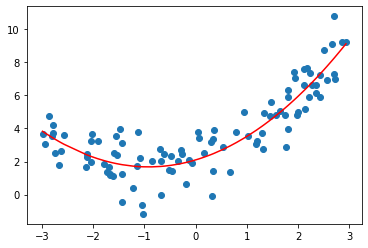

In [6]:
plt.scatter(x, y)
plt.plot(np.sort(x), y_predict2[np.argsort(x)], color='r')
plt.show()

In [7]:
lin_reg2.coef_ #权重

array([0.        , 0.91944911, 0.50078907])

In [8]:
lin_reg2.intercept_ #偏置

2.100492297462596

# Pipeline

对上述过程进行包装简化

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

poly_reg = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),  #多项式的特征
    ("std_scaler", StandardScaler()),  #数据的归一化
    ("lin_reg", LinearRegression())  #线性回归
])

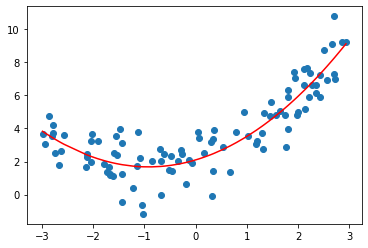

In [10]:
poly_reg.fit(X, y)
y_predict = poly_reg.predict(X)

plt.scatter(x, y)
plt.plot(np.sort(x), y_predict[np.argsort(x)], color='r')
plt.show()

## 过拟合和欠拟合

避免过拟合->增强模型的泛化能力，即获得对测试集的较高准确率

### 学习曲线

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [12]:
X_train.shape

(75, 1)

In [13]:
from sklearn.metrics import mean_squared_error #均方误差

train_score = []
test_score = []

for i in range(1, 76):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[:i], y_train[:i])
    
    y_train_predict = lin_reg.predict(X_train[:i])
    train_score.append(mean_squared_error(y_train[:i], y_train_predict))
    
    y_test_predict = lin_reg.predict(X_test)
    test_score.append(mean_squared_error(y_test, y_test_predict))

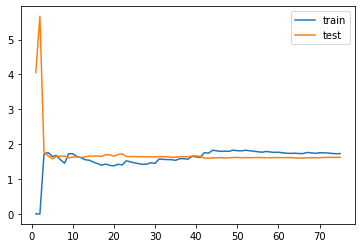

In [14]:
plt.plot([i for i in range(1, 76)], np.sqrt(train_score), label="train")
plt.plot([i for i in range(1, 76)], np.sqrt(test_score), label="test")
plt.legend()
plt.show()

## 交叉验证

将训练数据集划分为验证数据集和训练数据集，以便调整超参数

In [18]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

digit = datasets.load_digits()
X = digit.data
y = digit.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

best_score, best_p, best_k = 0, 0, 0

for k in range(2, 11):
    for p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        knn_clf.fit(X_train, y_train)
        score = knn_clf.score(X_test, y_test)
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print("best_score = ", best_score)
print("best_p = ", best_p)
print("best_k = ", best_k)

best_score =  0.9866666666666667
best_p =  2
best_k =  5


***
### 使用交叉验证实现调参

In [30]:
from sklearn.model_selection import cross_val_score #调用交叉验证包来实现调参

knn_clf = KNeighborsClassifier()
cross_val_score(knn_clf, X_train, y_train, cv=5) #cv为折数

array([0.98518519, 1.        , 0.98141264, 0.9739777 , 0.98141264])

In [20]:
best_score, best_p, best_k = 0, 0, 0

for k in range(2, 11):
    for p in range(1, 6):
        knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=k, p=p)
        knn_clf.fit(X_train, y_train)
        scores = cross_val_score(knn_clf, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_score, best_p, best_k = score, p, k

print("best_score = ", best_score)
print("best_p = ", best_p)
print("best_k = ", best_k)

best_score =  0.9873661021616412
best_p =  3
best_k =  9


In [21]:
best_knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=9, p=3)
best_knn_clf.fit(X_train, y_train)
best_knn_clf.score(X_test, y_test)

0.9844444444444445

### 网格搜索自带交叉验证

In [23]:
param_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(1,11)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(1,11)],
        'p':[i for i in range(1,6)]
    }
]

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_clf, param_grid)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=10, p=5,
                                            weights='distance'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform']},
                         {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'p': [1, 2, 3, 4, 5], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
grid_search.best_params_

{'n_neighbors': 9, 'p': 3, 'weights': 'distance'}

In [28]:
grid_search.best_score_

0.9873661021616412

In [29]:
best_knn_clf = grid_search.best_estimator_
best_knn_clf.score(X_test, y_test)

0.9844444444444445

# 偏差与方差

模型误差 = 偏差 + 方差 + 不可避免的误差

导致偏差的主要原因：对问题本身的假设不正确 -> 欠拟合

导致方差的主要原因：模型太过复杂 -> 过拟合

有一些算法天生是**高方差**的算法。如：KNN 

非参数学习通常都是**高方差**算法。因为不对数据进行任何假设 

有一些算法天生是**高偏差**算法。如：线性回归

参数学习通常都是**高偏差**算法。因为对数据具有极强的假设

解决高方差的手段：

1. 降低模型复杂度

2. 减少数据维度；降噪

3. 增加训练数据

4. 使用验证集

5. 模型正则化